In [47]:
from lxml import html
import requests, re, math
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
def parse_files_for_teams(fpath_3, fpath_w):
    d = dict()
    with open(fpath_3, "r") as file_3, open(fpath_w, "r") as file_w:
        pcts = [s.strip("\n") for s in list(file_3.readlines())]
        wins = [s.strip("\n") for s in list(file_w.readlines())]
        for i in range(len(pcts)):
            p = pcts[i]
            idx = p.find(".")
            team = p[:idx-1]
            three = float(p[idx:])
            w = wins[i]
            idx = w.find(".")
            team = w[:idx-1]
            win = float(w[idx:])
            d[team] = {'3pt_pct': three, 'win_pct': win}
        return d
        
team_info = parse_files_for_teams("teams_3pts.txt", "teams_win_pcts.txt")

In [3]:
def get_three_rate(D):
    for key1 in D.keys():
        s = []
        for key2 in D.keys():
            if not key1 == key2:
                s.append(D[key1]['3pt_pct'] / (D[key1]['3pt_pct'] + D[key2]['3pt_pct']))
        team_info[key1]['marginal'] = np.mean(s)
    return team_info
        
team_info = get_three_rate(team_info)

In [4]:
def get_scores_and_pbp(team, page):
    result = requests.get(page)
    tree = html.fromstring(result.content)
    tree = html.tostring(tree)
    soup = BeautifulSoup(tree, 'lxml')
    table = soup.find_all('table')[0]
    df = pd.read_html(table.prettify())[0]
    score = df.iloc[len(df)-2, 3]
    a_score, b_score = score.split('-')
    a_score = int(a_score)
    b_score = int(b_score)
    df = df.iloc[:, [1, 5]]
    cols = df.columns
    end = df.index[df[cols[0]] == "3rd Q"].tolist()[0]
    df = df.iloc[:end, :]
    df = df[~df[cols[0]].isin(['1st Q', '2nd Q', '3rd Q', '4th Q'])]
    df = df.iloc[1:, ]
    t = soup.title.string
    visitor = t[:(t.find(" at "))].strip()
    home = t[(t.find(" at ")+4):(t.find("Play")-1)].strip()
    df.columns = [visitor, home]
    won = True if (team == home and b_score > a_score) or (team == visitor and a_score > b_score) else False
    return won, df

In [5]:
def get_merged_plays(df):
    merged_plays = []
    for index, row in df.iterrows():
        for col in df.columns:
            if not pd.isnull(row[col]):
                merged_plays.append((col, row[col]))
    return merged_plays

In [6]:
def get_threes(cols, plays):
    threes = {cols[0]: 0, cols[1]: 0}
    for idx, event in enumerate(plays):
        if re.match(r'^(?=.*?\bmakes 3-pt\b).*$', event[1]):
            threes[event[0]] += 1
    return threes

In [7]:
def get_key(boool):
    if boool:
        return "won"
    else:
        return "lost"

In [8]:
def get_three_tally_by_team(team_info):
    folder_path = './box_links'
    for filename in glob.glob(os.path.join(folder_path, '*box_links.txt')):
        with open(filename, 'r') as f:
            tally = {'won': [0, 0], 'lost': [0, 0]}
            pages = [s.strip() for s in list(f.readlines())]
            team = pages[0]
            print(team)
            pages = pages[1:]
            for idx, page in enumerate(pages):
                if page.find("2021") != -1:
                    continue
                str_idx = page.find("boxscores/") + 10
                page = page[:str_idx] + "pbp/" + page[str_idx:]
                try:
                    won, df = get_scores_and_pbp(team, page)
                    plays = get_merged_plays(df)
                    threes = get_threes(df.columns, plays)
                    try:
                        for t in df.columns:
                            if t != team:
                                opponent = t
                        if (threes[team] >= threes[opponent]):
                            tally[get_key(won)][0] += 1
                        else:
                            tally[get_key(won)][1] += 1
                    except:
                        print("uh oh", team, opponent, page)
                except:
                    print("aight bet")
                    print()
            team_info[team]['tally'] = tally
    return team_info

team_info = get_three_tally_by_team(team_info)

Sacramento Kings
Utah Jazz
aight bet

Orlando Magic
aight bet

Charlotte Hornets
Denver Nuggets
Los Angeles Lakers
Phoenix Suns
Atlanta Hawks
Detroit Pistons
Golden State Warriors
aight bet

San Antonio Spurs
aight bet

Dallas Mavericks
aight bet

Cleveland Cavaliers
aight bet

Portland Trail Blazers
aight bet

New York Knicks
Houston Rockets
Memphis Grizzlies
New Orleans Pelicans
Indiana Pacers
Boston Celtics
Oklahoma City Thunder
Chicago Bulls
aight bet

Toronto Raptors
Milwaukee Bucks
Miami Heat
Washington Wizards
Los Angeles Clippers
Brooklyn Nets
Minnesota Timberwolves
Philadelphia 76ers


In [20]:
def bayes(team_info):
    # EXAMPLE: print(((tally[0] / sum(tally)) * jazz_win_rate)/0.54)
    for key in team_info.keys():
        try:
            likelihood = (team_info[key]['tally']['won'][0] / sum(team_info[key]['tally']['won']))
            prior = team_info[key]['win_pct']
            marginal = (likelihood * prior) + ((team_info[key]['tally']['lost'][0] / sum(team_info[key]['tally']['lost'])) * (1 - prior))
            posterior = (likelihood * prior) / marginal
            team_info[key]['marginal'] = marginal
            team_info[key]['posterior'] = posterior
        except:
            print(key)
    return team_info

team_info = bayes(team_info)
print(team_info)

{'Atlanta Hawks': {'3pt_pct': 0.333, 'win_pct': 0.299, 'marginal': 0.5374627659574469, 'tally': {'won': [15, 5], 'lost': [21, 26]}, 'posterior': 0.41723820551646323}, 'Philadelphia 76ers': {'3pt_pct': 0.368, 'win_pct': 0.589, 'marginal': 0.6011231190150479, 'tally': {'won': [28, 15], 'lost': [18, 16]}, 'posterior': 0.6380304992251167}, 'Brooklyn Nets': {'3pt_pct': 0.343, 'win_pct': 0.486, 'marginal': 0.6910271777003485, 'tally': {'won': [29, 6], 'lost': [23, 18]}, 'posterior': 0.5827349882616798}, 'Boston Celtics': {'3pt_pct': 0.364, 'win_pct': 0.667, 'marginal': 0.6433709677419355, 'tally': {'won': [41, 17], 'lost': [16, 15]}, 'posterior': 0.7328586828448946}, 'New York Knicks': {'3pt_pct': 0.337, 'win_pct': 0.318, 'marginal': 0.3181650793650793, 'tally': {'won': [8, 13], 'lost': [13, 32]}, 'posterior': 0.3807547245115843}, 'Toronto Raptors': {'3pt_pct': 0.374, 'win_pct': 0.736, 'marginal': 0.5310608695652175, 'tally': {'won': [33, 27], 'lost': [11, 12]}, 'posterior': 0.76224783861671

In [21]:
df = pd.DataFrame.from_dict(team_info, orient='index')
df

,3pt_pct,win_pct,marginal,tally,posterior
Atlanta Hawks,0.333,0.299,0.537463,"{'won': [15, 5], 'lost': [21, 26]}",0.417238
Boston Celtics,0.364,0.667,0.643371,"{'won': [41, 17], 'lost': [16, 15]}",0.732859
Brooklyn Nets,0.343,0.486,0.691027,"{'won': [29, 6], 'lost': [23, 18]}",0.582735
Charlotte Hornets,0.352,0.354,0.523077,"{'won': [12, 11], 'lost': [22, 20]}",0.353095
Chicago Bulls,0.348,0.338,0.577216,"{'won': [15, 7], 'lost': [22, 20]}",0.399252
Cleveland Cavaliers,0.351,0.292,0.437249,"{'won': [9, 10], 'lost': [19, 26]}",0.316332
Dallas Mavericks,0.367,0.573,0.803253,"{'won': [38, 6], 'lost': [26, 10]}",0.616075
Denver Nuggets,0.359,0.630,0.489273,"{'won': [27, 28], 'lost': [18, 19]}",0.632107
Detroit Pistons,0.367,0.303,0.636357,"{'won': [16, 4], 'lost': [26, 20]}",0.380919
Golden State Warriors,0.334,0.231,0.327220,"{'won': [8, 7], 'lost': [13, 36]}",0.376505


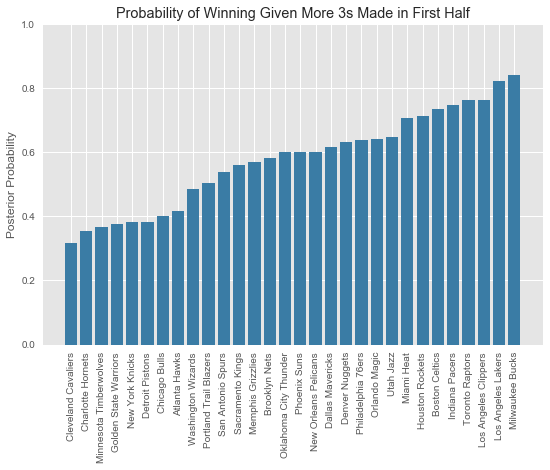

<Figure size 576x396 with 0 Axes>

In [50]:
y = []
for key in team_info.keys():
    y.append(team_info[key]['posterior'])
x = list(team_info.keys())
y, x = zip(*sorted(zip(y, x)))
fig = plt.figure()
plt.bar(x, y, color='#3a7ca5')
plt.ylim([0, 1])
plt.xticks(rotation=90)
plt.ylabel('Posterior Probability')
plt.title('Probability of Winning Given More 3s Made in First Half')
plt.show()
plt.tight_layout()
fig.savefig('./posterior_plot_all_teams.png', bbox_inches='tight')

In [26]:
np.mean(y)

0.576176667292711

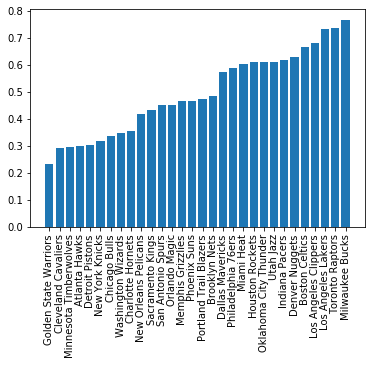

In [13]:
y = []
for key in team_info.keys():
    y.append(team_info[key]['win_pct'])
x = list(team_info.keys())
y, x = zip(*sorted(zip(y, x)))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# A = team X wins the game
# B = team X made more 3s in the first half, relative to team Y

# P(B|A) = likelihood = of all the games that team X won, what is the probability that they made more 3s in the first half
# P(A) = prior = team X win percentage (2019-2020 season)
# P(B) = marginal = P(B|A)P(A) + P(B|~A)P(~A)


# do this for multiple games
# average all P(A|B) at the end
